# Deep RNN - 2

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [10]:
# creating a instance
class StackedRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = [d2l.RNNScratch(num_inputs if i==0 else num_hiddens,
                                    num_hiddens, sigma)
                     for i in range(num_layers)]

In [13]:
# multilayer forward computation simply performs forward computation layer by layer
@d2l.add_to_class(StackedRNNScratch)
def forward(self, inputs, Hs=None):
    outputs = inputs
    if Hs is None: Hs = [None] * self.num_layers
    for i in range(self.num_layers):
        outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
        outputs = tf.stack(outputs, 0)
    return outputs, Hs

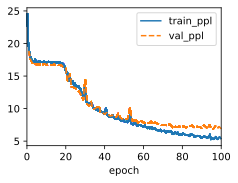

In [14]:
# output of The Time Machine dataset
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
with d2l.try_gpu():
    rnn_block = StackedRNNScratch(num_inputs=len(data.vocab),
                              num_hiddens=32, num_layers=2)
    model = d2l.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1)
trainer.fit(model, data)

In [15]:
# Multiple layer of GRU
class GRU(d2l.RNN):  #@save
    """The multilayer GRU model."""
    def __init__(self, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        gru_cells = [tf.keras.layers.GRUCell(num_hiddens, dropout=dropout)
                     for _ in range(num_layers)]
        self.rnn = tf.keras.layers.RNN(gru_cells, return_sequences=True,
                                       return_state=True, time_major=True)

    def forward(self, X, state=None):
        outputs, *state = self.rnn(X, state)
        return outputs, state

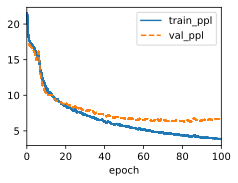

In [16]:
# The only difference is that we now select a nontrivial number of hidden layers by specifying the value of num_layers.
gru = GRU(num_hiddens=32, num_layers=2)
with d2l.try_gpu():
    model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)